M044_2024_12_04_09_30: VAF and Pairwise Correlation, all neurons

In [1]:
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pyaldata as pyal

from tools import dataTools as dt
from tools.dsp import preprocessing as prep
from tools import params

In [2]:
data_dir = "/Users/il620/Desktop/pose/raw"
session = "M044_2024_12_04_09_30"
fname = os.path.join(data_dir, session+"_pyaldata.mat")

In [3]:
df = pyal.mat2dataframe(fname, shift_idx_fields=True)


field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


In [4]:
df.columns

Index(['animal', 'session', 'trial_id', 'trial_name', 'trial_length',
       'bin_size', 'idx_trial_start', 'idx_trial_end', 'idx_CPI',
       'values_before_camera_trigger', 'idx_before_camera_trigger',
       'idx_motion', 'values_Sol_direction', 'idx_Sol_direction',
       'values_Sol_duration', 'idx_Sol_duration', 'idx_sol_on',
       'idx_earthquake_duration', 'idx_session_timer', 'all_chan_best',
       'all_unit_guide', 'all_KSLabel', 'all_spikes'],
      dtype='object')

In [4]:
df_ = prep.preprocess(df)

/Users/il620/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


In [6]:
df_.columns

Index(['animal', 'session', 'trial_id', 'trial_name', 'trial_length',
       'bin_size', 'idx_trial_start', 'idx_trial_end', 'idx_CPI',
       'values_before_camera_trigger', 'idx_before_camera_trigger',
       'idx_motion', 'values_Sol_direction', 'idx_Sol_direction',
       'values_Sol_duration', 'idx_Sol_duration', 'idx_sol_on',
       'idx_earthquake_duration', 'idx_session_timer', 'all_chan_best',
       'all_unit_guide', 'all_KSLabel', 'all_spikes', 'all_rates'],
      dtype='object')

In [5]:
data_list = [df_]
areas = ["all"]
n_components = 474
epoch = None
model = "pca"

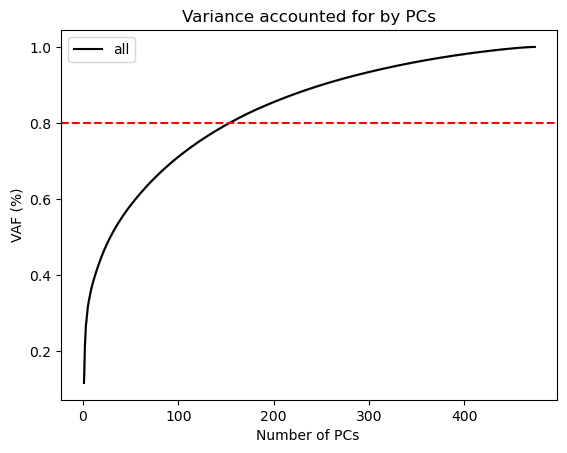

In [ ]:
# VAF for each area in areas list, averaged across sessions in data_list, with shaded errorbars.
fig, ax = plt.subplots()
dt.plot_VAF(ax = ax, data_list = data_list, areas = areas, n_components = n_components, epoch = epoch, model = model)

In [10]:
from sklearn.decomposition import PCA
from tools.viz import utilityTools as utility
def plot_VAF(ax, data_list: list[pd.DataFrame], epoch=None, areas=["all"], model = None, n_components=10, n_neighbors=10):
    '''
    Plot VAF for each area in areas list, averaged across sessions in data_list, with shaded errorbars.
    '''
    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    if isinstance(areas, str):
        areas = [areas]
    if isinstance(areas, dict):
        units_per_area = list(areas.values())
        areas = list(areas.keys())
    else:    
        units_per_area = None
        
    for i,area in enumerate(areas):
        field = f'{area}_rates' if units_per_area is None else 'all_rates'
        VAF_per_area = []
        for session, df in enumerate(data_list):
            df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
            rates = np.concatenate(df_[field].values, axis=0) 
            if units_per_area is not None:
                rates = rates[:, units_per_area[i][0]:units_per_area[i][1]]
                n_components = rates.shape[-1]
            model = PCA(n_components=n_components, svd_solver='full')
            rates_model = model.fit(rates)
            if isinstance(model, PCA):
                explained_variance_ratio = model.explained_variance_ratio_
            cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
            VAF_per_area.append(cumulative_explained_variance_ratio)
        x_ = np.arange(1, n_components + 1)
        utility.shaded_errorbar(ax, x_,  np.array(VAF_per_area).T ,label = area,color = getattr(params.colors, area, "k"))
        
    ax.set_xlabel('Number of PCs ')
    ax.set_ylabel('VAF (%)')
    ax.set_title('Variance accounted for by PCs')
    ax.axhline(y=0.8, color='red', linestyle='--')
    ax.legend()
    plt.show()

In [6]:
areas = {"Dls": (0,300), 'M1': (300, 474)}

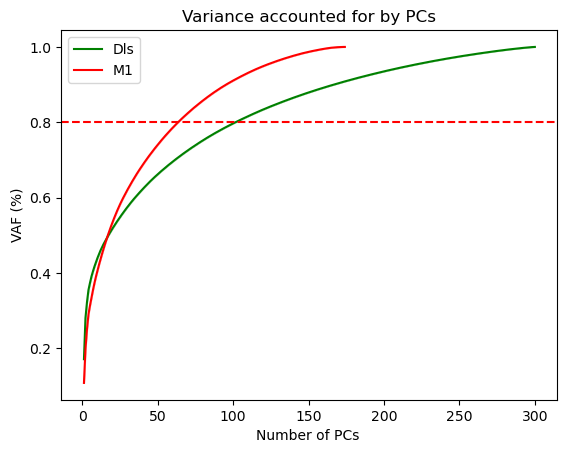

In [11]:
# VAF for each area in areas list, averaged across sessions in data_list, with shaded errorbars.
fig, ax = plt.subplots()
plot_VAF(ax = ax, data_list = data_list, areas = areas, n_components = n_components, epoch = epoch, model = model)

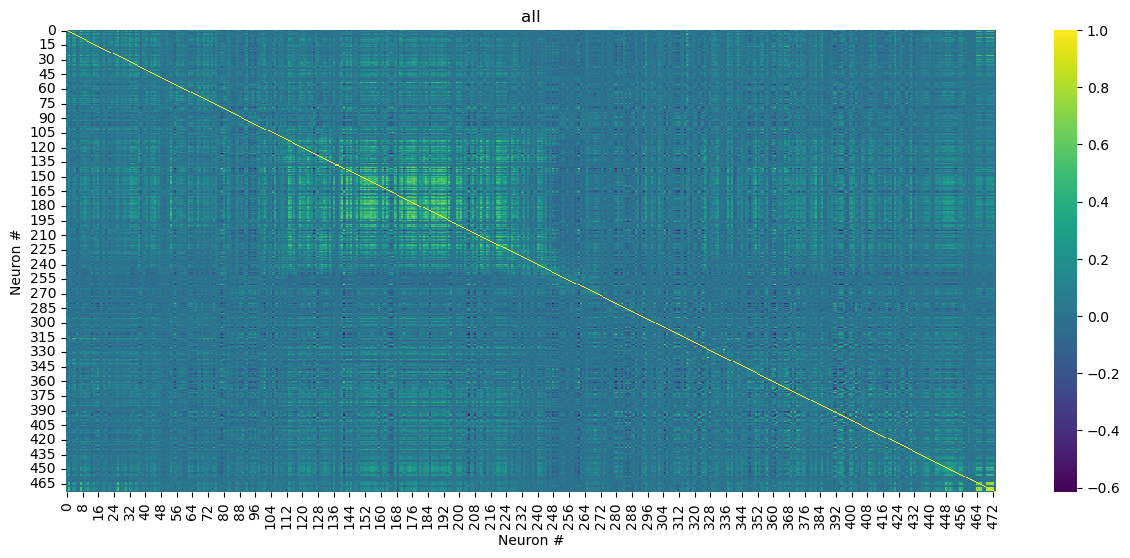

In [6]:
# Pairwise correlation for one session for each area in areas list
fig, axes = plt.subplots(1, len(areas), figsize=(15, 6))
dt.plot_pairwise_corr(axes,df_, areas = areas, epoch = epoch)